<a href="https://colab.research.google.com/github/rizkyabdillah127/Facial_Detection_System-/blob/main/Training_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pillow-heif facenet-pytorch -q

import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import json
import copy
import random
from tqdm import tqdm
from PIL import Image, ImageFile, ImageFilter
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from facenet_pytorch import MTCNN, InceptionResnetV1
import pillow_heif

# Register HEIF opener
pillow_heif.register_heif_opener()
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Setup Selesai. Device: {device}")

✅ Setup Selesai. Device: cuda


In [ ]:
# KONFIGURASI PATH
RAW_DATA_DIR = '/content/drive/MyDrive/Train/Mahasiswa'
PROCESSED_DIR = '/content/dataset_processed'
IMG_SIZE = 224
BATCH_SIZE = 32

if os.path.exists(PROCESSED_DIR): shutil.rmtree(PROCESSED_DIR)
os.makedirs(PROCESSED_DIR)

print(f"🚀 Memproses Data dari: {RAW_DATA_DIR}")

valid_count = 0
folders = [d for d in os.listdir(RAW_DATA_DIR) if os.path.isdir(os.path.join(RAW_DATA_DIR, d))]

for class_name in tqdm(folders):
    src_path = os.path.join(RAW_DATA_DIR, class_name)
    dst_path = os.path.join(PROCESSED_DIR, class_name)
    os.makedirs(dst_path, exist_ok=True)

    for fname in os.listdir(src_path):
        fpath = os.path.join(src_path, fname)
        if not os.path.isfile(fpath): continue

        try:
            # 1. Buka Gambar (Support HEIC/JPG/PNG)
            img = Image.open(fpath)

            # 2. Convert ke RGB (Fix RGBA/Palette)
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # 3. Resize Awal
            img = img.resize((IMG_SIZE, IMG_SIZE))

            # 4. Simpan sebagai JPG Bersih
            save_name = os.path.splitext(fname)[0] + ".jpg"
            img.save(os.path.join(dst_path, save_name), quality=95)
            valid_count += 1
        except Exception as e:
            continue

    # Hapus folder jika kosong
    if len(os.listdir(dst_path)) == 0:
        os.rmdir(dst_path)

print(f"✅ Data Bersih: {valid_count} foto di '{PROCESSED_DIR}'")

🚀 Memproses Data dari: /content/drive/MyDrive/Train/Mahasiswa


100%|██████████| 75/75 [00:43<00:00,  1.72it/s]

✅ Data Bersih: 290 foto di '/content/dataset_processed'


In [ ]:
def get_dataloaders():
    # Augmentasi Stabil (Tidak merusak wajah)
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        full_dataset = datasets.ImageFolder(PROCESSED_DIR)
    except:
        print("❌ Dataset kosong!")
        return None, 0, []

    # Split 80% Train - 20% Val
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_data, val_data = random_split(full_dataset, [train_size, val_size])

    # Apply Transforms
    class MapDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, transform):
            self.dataset = dataset
            self.transform = transform
        def __getitem__(self, index):
            x, y = self.dataset[index]
            return self.transform(x), y
        def __len__(self): return len(self.dataset)

    loaders = {
        'train': DataLoader(MapDataset(train_data, train_transform), batch_size=BATCH_SIZE, shuffle=True),
        'val': DataLoader(MapDataset(val_data, val_transform), batch_size=BATCH_SIZE, shuffle=False)
    }

    return loaders, len(full_dataset.classes), full_dataset.classes

dataloaders, num_classes, class_names = get_dataloaders()
print(f"📊 Dataset Info: {num_classes} Kelas | Train: {len(dataloaders['train'].dataset)} | Val: {len(dataloaders['val'].dataset)}")

📊 Dataset Info: 70 Kelas | Train: 232 | Val: 58


In [ ]:
# --- CELL 1: SETUP & DATA LOADER ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from facenet_pytorch import InceptionResnetV1
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

# KONFIGURASI
CROPPED_DATA_DIR = '/content/dataset_processed' # Pastikan folder ini ada isinya!
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_dataloaders():
    # Transformasi Standar
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        dataset = datasets.ImageFolder(CROPPED_DATA_DIR, transform=transform)
    except:
        print("❌ Error: Folder dataset kosong/tidak ketemu.")
        return None, 0, []

    # Split 80% Train, 20% Val
    train_len = int(0.8 * len(dataset))
    val_len = len(dataset) - train_len
    train_data, val_data = random_split(dataset, [train_len, val_len])

    loaders = {
        'train': DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True),
        'val': DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
    }
    return loaders, len(dataset.classes), dataset.classes

dataloaders, num_classes, class_names = get_dataloaders()
print(f"✅ Siap Training! Kelas: {num_classes} | Train: {len(dataloaders['train'].dataset)} | Val: {len(dataloaders['val'].dataset)}")

✅ Siap Training! Kelas: 70 | Train: 232 | Val: 58


In [ ]:
# --- CELL: FASE 2 - FINE TUNING (BOOST AKURASI) ---
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy

def run_finetuning(model_name, num_epochs=25):
    print(f"\n🚀 MEMULAI FASE 2: FINE-TUNING (UNFREEZE) UNTUK {model_name.upper()}")

    # 1. LOAD MODEL TERBAIK DARI FASE 1
    # Kita load lagi biar start dari kondisi terbaik yang sudah dipelajari
    model_path = f'model_{model_name}_final.pth'
    if not os.path.exists(model_path):
        print("❌ Harap jalankan training Fase 1 dulu sampai selesai!")
        return {}

    print("🔓 Membuka Kunci Backbone (Unfreeze)...")

    # Re-build architecture & Load weights
    if model_name == 'inception':
        model = InceptionResnetV1(pretrained='vggface2', classify=True)
        model.logits = nn.Linear(model.logits.in_features, num_classes)
        model.load_state_dict(torch.load(model_path))
    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        model.load_state_dict(torch.load(model_path))

    model = model.to(DEVICE)

    # 2. UNFREEZE TOTAL (Buka semua gembok)
    # Sekarang seluruh otak boleh belajar, tapi pelan-pelan
    for param in model.parameters():
        param.requires_grad = True

    # 3. SETTING OPTIMIZER KHUSUS (LOW LEARNING RATE)
    # Kita pakai LR sangat kecil (1e-5) agar ilmu lama tidak rusak
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    history = {'train_loss': [], 'val_acc': []}
    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f"Ep {epoch+1}/{num_epochs}: ", end="")

        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            running_corrects = 0
            running_loss = 0
            total = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_corrects += torch.sum(preds == labels.data)
                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)

            if phase == 'train':
                scheduler.step()
                history['train_loss'].append(running_loss/total)
                print(f"Loss: {running_loss/total:.4f} | ", end="")
            else:
                acc = running_corrects.double() / total
                history['val_acc'].append(acc.item())
                print(f"Val Acc: {acc:.4f}", end="")

                if acc > best_acc:
                    best_acc = acc
                    best_wts = copy.deepcopy(model.state_dict())
                    print(" 🔥NAIK!", end="")
        print()

    print(f"🏆 Selesai Fine-Tuning! Final Best Acc: {best_acc:.4f}")

    # Simpan Model Versi Final-Tuned
    save_name = f"model_{model_name}_tuned.pth"
    model.load_state_dict(best_wts)
    torch.save(model.state_dict(), save_name)
    print(f"💾 Model tersimpan: {save_name}")
    return history

# --- EKSEKUSI BOOSTER ---
# Jalankan ini untuk model Inception dulu
hist_tuned_inc = run_finetuning('inception', num_epochs=20)

# Kalau mau EfficientNet juga di-boost:
# hist_tuned_eff = run_finetuning('efficientnet', num_epochs=20)


🚀 MEMULAI FASE 2: FINE-TUNING (UNFREEZE) UNTUK INCEPTION
❌ Harap jalankan training Fase 1 dulu sampai selesai!


In [ ]:
# --- CELL 5: TRAINING ENGINE LENGKAP ---
import torch.optim as optim
import copy
import time
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_engine(model, name, num_epochs=30):
    print(f"\n🚀 START TRAINING: {name}")
    print(f"{'Epoch':<8} | {'LR':<10} | {'Time':<8} | {'Train Loss':<10} | {'Train Acc':<10} | {'Val Acc':<10}")
    print("-" * 75)

    # Setup
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, weight_decay=1e-3)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    # History Container
    history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}
    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())

    total_start = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # Ambil Learning Rate saat ini
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)

        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            running_corrects = 0
            running_loss = 0
            total = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_corrects += torch.sum(preds == labels.data)
                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)

            # Hitung Statistik Phase Ini
            epoch_acc = running_corrects.double() / total
            epoch_loss = running_loss / total

            if phase == 'train':
                scheduler.step()
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                train_loss_val = epoch_loss
                train_acc_val = epoch_acc.item()
            else:
                history['val_acc'].append(epoch_acc.item())
                val_acc_val = epoch_acc.item()

                # Cek Model Terbaik
                star = ""
                if val_acc_val > best_acc:
                    best_acc = val_acc_val
                    best_wts = copy.deepcopy(model.state_dict())
                    star = "⭐"

        # Hitung Waktu Epoch
        epoch_time = time.time() - epoch_start

        # PRINT FORMAT RAPI
        print(f"{epoch+1}/{num_epochs:<5} | {current_lr:.6f}   | {epoch_time:.0f}s      | {train_loss_val:.4f}     | {train_acc_val:.4f}     | {val_acc_val:.4f} {star}")

    total_time = time.time() - total_start
    print("-" * 75)
    print(f"🏁 Selesai dalam {total_time//60:.0f}m {total_time%60:.0f}s")
    print(f"🏆 Best Validation Accuracy: {best_acc:.4f}")

    model.load_state_dict(best_wts)
    return model, history

In [ ]:
# --- CELL 4: EKSEKUSI ---
import json

# 1. Training Inception (FaceNet)
model_inc = build_frozen_model('inception', num_classes)
model_inc, hist_inc = train_model(model_inc, "InceptionV1 (Frozen)", num_epochs=20)
torch.save(model_inc.state_dict(), 'model_inception_baru.pth')

# 2. Training EfficientNet
model_eff = build_frozen_model('efficientnet', num_classes)
model_eff, hist_eff = train_model(model_eff, "EfficientNet (Frozen)", num_epochs=20)
torch.save(model_eff.state_dict(), 'model_efficientnet_baru.pth')

# Simpan Nama Kelas
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

❄️ Membangun inception (Mode: Frozen Backbone)...

🚀 Start Training: InceptionV1 (Frozen)
Epoch 1/20: Loss: 4.2787 | Val Acc: 0.0000
Epoch 2/20: Loss: 3.3504 | Val Acc: 0.1552 ⭐
Epoch 3/20: Loss: 2.6595 | Val Acc: 0.2414 ⭐
Epoch 4/20: Loss: 2.1616 | Val Acc: 0.2759 ⭐
Epoch 5/20: Loss: 1.7408 | Val Acc: 0.3276 ⭐
Epoch 6/20: Loss: 1.4458 | Val Acc: 0.3103
Epoch 7/20: Loss: 1.1799 | Val Acc: 0.3276
Epoch 8/20: Loss: 1.1653 | Val Acc: 0.3448 ⭐
Epoch 9/20: Loss: 1.0621 | Val Acc: 0.3448
Epoch 10/20: Loss: 1.0935 | Val Acc: 0.3448
Epoch 11/20: Loss: 1.0776 | Val Acc: 0.3276
Epoch 12/20: Loss: 1.0164 | Val Acc: 0.3448
Epoch 13/20: Loss: 1.0224 | Val Acc: 0.3276
Epoch 14/20: Loss: 1.0259 | Val Acc: 0.3448
Epoch 15/20: Loss: 1.0027 | Val Acc: 0.3448
Epoch 16/20: Loss: 1.0335 | Val Acc: 0.2586
Epoch 17/20: Loss: 1.0224 | Val Acc: 0.3448
Epoch 18/20: Loss: 1.0102 | Val Acc: 0.3103
Epoch 19/20: Loss: 0.9729 | Val Acc: 0.3448
Epoch 20/20: Loss: 0.9773 | Val Acc: 0.3448
🏁 Selesai! Best Accuracy: 0.3

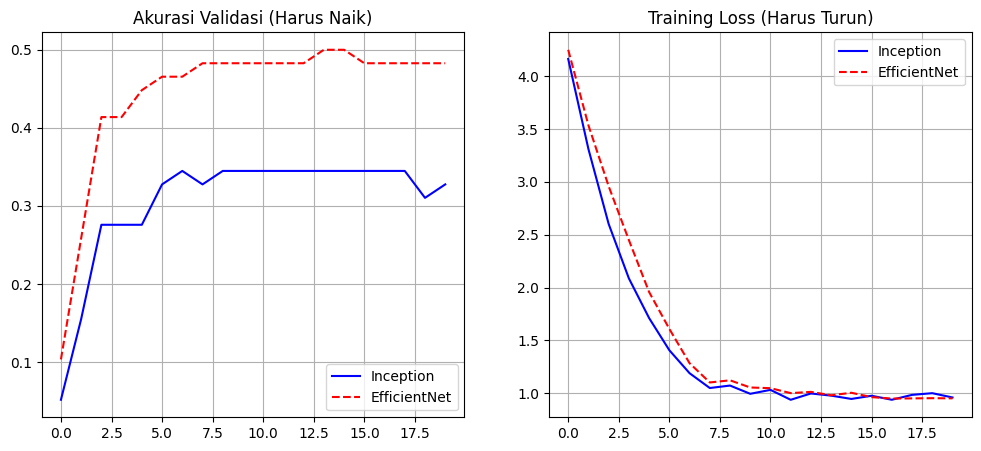

In [ ]:
# --- CELL 5: VISUALISASI ---
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(hist_inc['val_acc'], 'b-', label='Inception')
plt.plot(hist_eff['val_acc'], 'r--', label='EfficientNet')
plt.title("Akurasi Validasi (Harus Naik)")
plt.legend(); plt.grid()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(hist_inc['train_loss'], 'b-', label='Inception')
plt.plot(hist_eff['train_loss'], 'r--', label='EfficientNet')
plt.title("Training Loss (Harus Turun)")
plt.legend(); plt.grid()

plt.show()